In [41]:
%matplotlib inline
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy.stats import percentileofscore
import warnings
warnings.filterwarnings('ignore')

### Helper functions

In [42]:
def plot_roc(fpr, tpr, roc_auc, color='darkorange', label=''):
    plt.plot(fpr, tpr, color=color,
             lw=2, label=label + 'ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize='x-large')
    plt.ylabel('True Positive Rate', fontsize='x-large')
    plt.legend(loc="lower right")
    plt.tight_layout()

### Read data files

In [65]:
df_all = pd.read_csv('./data/data_all.csv')
df_all.fillna(0, inplace=True)
df_all.Calcs1.replace(0, 'None', inplace=True)

df_dl = pd.read_csv('./data/predictions_cv.csv')
df_dl_train = pd.read_csv('./data/predictions_cv_train.csv')
df_dl_fold = {}
for i in range(10):
    df_dl_fold[i] = df_dl_train[df_dl_train.Fold == i]

### Feature processing and engineering

In [66]:
categorical_features = ['Composition', 'Echogenicity', 'Shape', 'Calcs1', 'Calcs2', 'Calcs3', 'MargA']

In [67]:
df_all_categorical = df_all[categorical_features]
df_all_categorical = pd.get_dummies(df_all_categorical)

In [68]:
df_features = df_all_categorical
df_features['Calcs_None'] = df_features.Calcs1_None
df_features['Calcs_Peripheral_eggshell'] = df_features.Calcs1_Peripheral_eggshell + df_features.Calcs2_Peripheral_eggshell + df_features.Calcs3_Peripheral_eggshell
df_features['Calcs_Colloid'] = df_features.Calcs1_Colloid + df_features.Calcs2_Colloid
df_features['Calcs_Macro'] = df_features.Calcs1_Macro + df_features.Calcs2_Macro
df_features['Calcs_PEF'] = df_features.Calcs1_PEF + df_features.Calcs2_PEF
df_features.drop(columns=['Shape_0', 'Calcs1_None', 'Calcs2_0', 'Calcs3_0'], inplace=True)
df_features.drop(columns=['Calcs1_Peripheral_eggshell', 'Calcs2_Peripheral_eggshell', 'Calcs3_Peripheral_eggshell'], inplace=True)
df_features.drop(columns=['Calcs1_Colloid', 'Calcs2_Colloid'], inplace=True)
df_features.drop(columns=['Calcs1_Macro', 'Calcs2_Macro'], inplace=True)
df_features.drop(columns=['Calcs1_PEF', 'Calcs2_PEF'], inplace=True)
print(df_features.columns)

Index([u'Composition_Cannot tell', u'Composition_Cystic',
       u'Composition_Entirely or almost entirely solid',
       u'Composition_Mixed cystic_solid', u'Composition_Spongiform',
       u'Echogenicity_Cant classify', u'Echogenicity_Hyper',
       u'Echogenicity_Iso', u'Echogenicity_Mild Hypo',
       u'Echogenicity_Very Hypo', u'Shape_cant assess', u'Shape_n', u'Shape_y',
       u'MargA_Cant classify', u'MargA_Ill-defined', u'MargA_Lobulated',
       u'MargA_Well-defined', u'Calcs_None', u'Calcs_Peripheral_eggshell',
       u'Calcs_Colloid', u'Calcs_Macro', u'Calcs_PEF'],
      dtype='object')


### Remove rows not present in deep learning data frame

In [69]:
df_features['ID'] = df_all['ID']
cv_ids = np.intersect1d(df_all['ID'], df_dl['ID'])
df_features = df_features[df_features.ID.isin(cv_ids)]
df_cv = df_all[df_all.ID.isin(cv_ids)]
print(len(df_features))

1278


### Get size for TI-RADS and DL

In [70]:
df_all['Size'] = df_all.apply(lambda x: max(x.Length, x.Width, x.Thickness), axis=1)
df_features = df_features.merge(df_all[['ID', 'Size']], on='ID')
size_tirads = df_features['Size'].as_matrix().flatten()
features_ids = df_features['ID'].as_matrix().flatten()
df_features.drop(columns=['ID', 'Size'], inplace=True)

df_dl = df_dl.merge(df_all[['ID', 'Size']], on='ID')
size_dl = df_dl['Size'].as_matrix().flatten()

### Prediction based on TI-RADS

In [71]:
w = np.array([[2, 0, 2, 1, 0, 1, 1, 1, 2, 3, 0, 0, 3, 0, 0, 2, 0, 0, 2, 0, 1, 3]])

X_cv = df_features.as_matrix()

x_cyst = X_cv[:, 1]
x_cyst = np.abs(x_cyst - 1)
x_spon = X_cv[:, 4]
x_spon = np.abs(x_spon - 1)

X_cv = X_cv * np.expand_dims(x_cyst, axis=-1)
X_cv = X_cv * np.expand_dims(x_spon, axis=-1)

tirads_points_cv = np.dot(X_cv, w.T).flatten()

y_true_tirads_cv = df_cv.Cancer

y_pred_tirads_cv_follow = np.zeros_like(tirads_points_cv)
for i in range(len(tirads_points_cv)):
    p = tirads_points_cv[i]
    s = size_tirads[i]
    if (p == 3 and s >= 15) or (4 <= p <= 6 and s >= 10) or (p >= 7 and s >= 5):
        y_pred_tirads_cv_follow[i] = 1.

y_pred_tirads_cv_fna = np.zeros_like(tirads_points_cv)
for i in range(len(tirads_points_cv)):
    p = tirads_points_cv[i]
    s = size_tirads[i]
    if (p == 3 and s >= 25) or (4 <= p <= 6 and s >= 15) or (p >= 7 and s >= 10):
        y_pred_tirads_cv_fna[i] = 1.

### Deep learning

In [72]:
dl_level3_p = percentileofscore(tirads_points_cv, 2.5)
dl_level4_p = percentileofscore(tirads_points_cv, 3.5)
dl_level5_p = percentileofscore(tirads_points_cv, 6.5)
print('dl_level3_p = {}'.format(dl_level3_p))
print('dl_level4_p = {}'.format(dl_level4_p))
print('dl_level5_p = {}'.format(dl_level5_p))

dl_level3_p = 23.2394366197
dl_level4_p = 43.2707355243
dl_level5_p = 81.220657277


In [73]:
y_score_dl_cv = df_dl['Prediction'].as_matrix()
y_true_dl_cv = df_dl['Cancer'].as_matrix()
y_dl_fold = df_dl['Fold'].as_matrix()
df_features['ID'] = features_ids
df_features['Points'] = tirads_points_cv
df_features = df_features.merge(df_dl[['ID', 'Fold']], on='ID')

# dl_level3_p_fold = {}
# dl_level4_p_fold = {}
# dl_level5_p_fold = {}
# for i in range(10):
#     tirads_points_cv_fold = df_features[df_features.Fold == 1]['Points'].as_matrix().flatten()
#     dl_level3_p_fold[i] = percentileofscore(tirads_points_cv_fold, 2.5)
#     dl_level4_p_fold[i] = percentileofscore(tirads_points_cv_fold, 3.5)
#     dl_level5_p_fold[i] = percentileofscore(tirads_points_cv_fold, 6.5)

dl_th3_fold = {}
dl_th4_fold = {}
dl_th5_fold = {}
for i in range(10):
    y_score_dl_cv_train = df_dl_fold[i]['Prediction'].as_matrix()
    y_true_dl_cv_train = df_dl_fold[i]['Cancer'].as_matrix()
#     dl_level3_p = dl_level3_p_fold[i]
#     dl_level4_p = dl_level4_p_fold[i]
#     dl_level5_p = dl_level5_p_fold[i]
    dl_th3_fold[i] = np.percentile(y_score_dl_cv_train, dl_level3_p)
    dl_th4_fold[i] = np.percentile(y_score_dl_cv_train, dl_level4_p)
    dl_th5_fold[i] = np.percentile(y_score_dl_cv_train, dl_level5_p)

dl_th3 = np.mean(dl_th3_fold.values())
dl_th4 = np.mean(dl_th4_fold.values())
dl_th5 = np.mean(dl_th5_fold.values())

print('dl_th3 = {}'.format(dl_th3))
print('dl_th4 = {}'.format(dl_th4))
print('dl_th5 = {}'.format(dl_th5))

y_pred_dl_cv_follow = np.zeros_like(y_score_dl_cv)
for i in range(len(y_score_dl_cv)):
    p = y_score_dl_cv[i]
    s = size_dl[i]
#     dl_th3 = dl_th3_fold[y_dl_fold[i]]
#     dl_th4 = dl_th4_fold[y_dl_fold[i]]
#     dl_th5 = dl_th5_fold[y_dl_fold[i]]
    if (dl_th3 < p <= dl_th4 and s >= 15) or (dl_th4 < p <= dl_th5 and s >= 10) or (dl_th5 < p and s >= 5):
        y_pred_dl_cv_follow[i] = 1.

y_pred_dl_cv_fna = np.zeros_like(y_score_dl_cv)
for i in range(len(y_score_dl_cv)):
    p = y_score_dl_cv[i]
    s = size_dl[i]
    if (dl_th3 < p <= dl_th4 and s >= 25) or (dl_th4 < p <= dl_th5 and s >= 15) or (dl_th5 < p and s >= 10):
        y_pred_dl_cv_fna[i] = 1.

dl_th3 = 0.342462082039
dl_th4 = 0.433435710508
dl_th5 = 0.617465653071


### Results analysis

In [74]:
fpr_dl, tpr_dl, _ = roc_curve(y_true_dl_cv, y_score_dl_cv)
roc_auc_dl = roc_auc_score(y_true_dl_cv, y_score_dl_cv)

fpr_tirads, tpr_tirads, _ = roc_curve(y_true_tirads_cv, tirads_points_cv)
roc_auc_tirads = roc_auc_score(y_true_tirads_cv, tirads_points_cv)

fpr, tpr, _ = roc_curve(y_true_dl_cv, y_pred_dl_cv_follow)
fpr_dl_point_follow = fpr[1]
tpr_dl_point_follow = tpr[1]

fpr, tpr, _ = roc_curve(y_true_dl_cv, y_pred_dl_cv_fna)
fpr_dl_point_fna = fpr[1]
tpr_dl_point_fna = tpr[1]

fpr, tpr, _ = roc_curve(y_true_tirads_cv, y_pred_tirads_cv_follow)
fpr_tirads_point_follow = fpr[1]
tpr_tirads_point_follow = tpr[1]

fpr, tpr, _ = roc_curve(y_true_tirads_cv, y_pred_tirads_cv_fna)
fpr_tirads_point_fna = fpr[1]
tpr_tirads_point_fna = tpr[1]

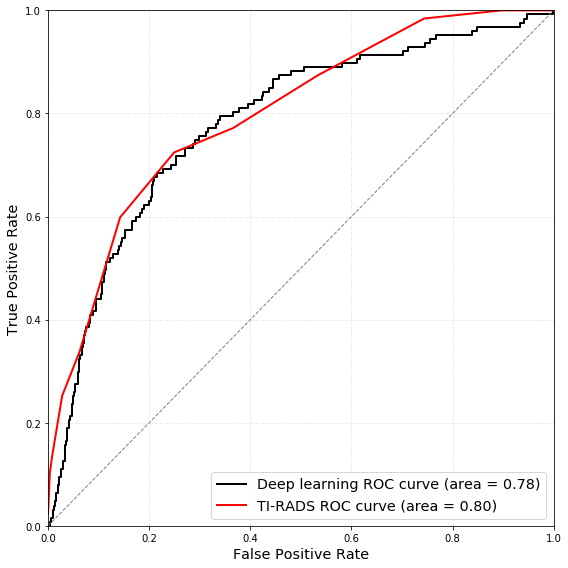

In [76]:
plt.figure(figsize=(8, 8))
plot_roc(fpr_dl, tpr_dl, roc_auc_dl, color='black', label='Deep learning ')
plot_roc(fpr_tirads, tpr_tirads, roc_auc_tirads, color='red', label='TI-RADS ')
# plt.scatter(fpr_dl_point_fna, tpr_dl_point_fna, s=196, color='black', marker='+', label='Deep learning (FNA)')
# plt.scatter(fpr_tirads_point_fna, tpr_tirads_point_fna, s=196, color='red', marker='+', label='TI-RADS (FNA)')
# plt.scatter(fpr_dl_point_follow, tpr_dl_point_follow, s=144, color='black', marker='x', label='Deep learning (follow-up)')
# plt.scatter(fpr_tirads_point_follow, tpr_tirads_point_follow, s=144, color='red', marker='x', label='TI-RADS (follow-up)')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.title('', fontsize='xx-large')
plt.legend(loc='lower right', fontsize='x-large')
plt.grid(color='silver', alpha=0.3, linestyle='--', linewidth=1)